不同于线性回归使用于连续值，softmax的输出单元更多，适用于离散值的预测和训练

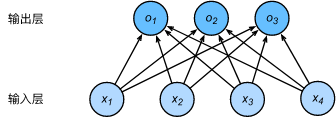

$\hat y_1$,$\hat y_2$,$\hat y_3$ = $softmax(o_1,o_2,0_3)$    
$\hat y_1$+$\hat y_2$+$\hat y_3$ = 1

交叉熵损失函数 cross entropy，一般用于衡量两个概率分布差异    
$$H(y^{(i)},\hat y^{(i)}) = -\sum_{j=1}^q y_j^{(i)}\log \hat y_j^{(i)}$$ $$Loss = \frac{1}{n}\sum_{i=1}^n H(y^{(i)},\hat y^{(i)})$$   
$y_j^{(i)}$是真实值，0 或者 1

# 图像分类数据集 Fashion-MNIST
比手写数据及更加复杂的数据集，更加适合观察模型差异    
Fashion-MNIST中一共包括了10个类别，分别为t-shirt（T恤）、trouser（裤子）、pullover（套衫）、dress（连衣裙）、coat（外套）、sandal（凉鞋）、shirt（衬衫）、sneaker（运动鞋）、bag（包）和ankle boot（短靴）。以下函数可以将数值标签转成相应的文本标签。

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import time
import sys
sys.path.append("..")
import d2lzh_pytorch as d2l

transforms.ToTensor()可以将尺寸为(H x W x C)且数据位于[0,255]的PIL图片或者UNIT8的numpy数组转换为(C x H x W)的float32且谓语[0.0, 1.0]的tensor

建议如果使用像素值[0,255]表示图片数据，一律设置为unit8

In [2]:
mnist_train = torchvision.datasets.FashionMNIST(root='~/Datasets/FashionMNIST', train=True, download=True, transform=transforms.ToTensor())
mnist_test = torchvision.datasets.FashionMNIST(root='~/Datasets/FashionMNIST', train=False, download=True, transform=transforms.ToTensor())

In [3]:
print(type(mnist_train))
print(len(mnist_train), len(mnist_test))

<class 'torchvision.datasets.mnist.FashionMNIST'>
60000 10000


In [4]:
feature, label = mnist_train[0]
print(feature.shape, label)  # Channel x Height x Width

torch.Size([1, 28, 28]) 9


In [5]:
# 本函数已保存在d2lzh包中方便以后使用
def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

In [6]:
# 本函数已保存在d2lzh包中方便以后使用
def show_fashion_mnist(images, labels):
    d2l.use_svg_display()
    # 这里的_表示我们忽略（不使用）的变量
    _, figs = plt.subplots(1, len(images), figsize=(12, 12))
    for f, img, lbl in zip(figs, images, labels):
        f.imshow(img.view((28, 28)).numpy())
        f.set_title(lbl)
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)
    plt.show()

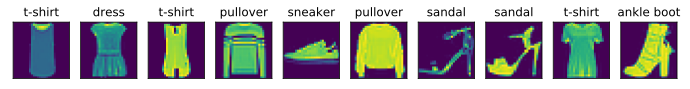

In [7]:
X, y = [],[]
for i in range(2,12):
    X.append(mnist_train[i][0])
    y.append(mnist_train[i][1])
show_fashion_mnist(X, get_fashion_mnist_labels(y))

In [8]:
# 小批量读取
batch_size = 256
if sys.platform.startswith('win'):
    num_workers = 0
else:
    num_workers = 4

train_iter = torch.utils.data.DataLoader(mnist_train, batch_size, 
                                         shuffle=True, num_workers=num_workers)
test_iter = torch.utils.data.DataLoader(mnist_test, batch_size,
                                       shuffle=False, num_workers=num_workers)

In [9]:
%%time
for X,y in train_iter:
    continue

CPU times: user 95.8 ms, sys: 61.3 ms, total: 157 ms
Wall time: 1.46 s


# 从0开始实现softmax

## 初始化模型参数
每个样本是28 x 28，所以输入向量为 784，输出层为labels的one-hot形式，10个类别，所以权重矩阵w为784 x 10, 偏差参数为1x10

In [10]:
num_inputs = 784
num_outputs = 10

W = torch.tensor(np.random.normal(0, 0.01, (num_inputs, num_outputs)), dtype=torch.float)
b = torch.zeros(num_outputs, dtype=torch.float)

# 需要梯度
W.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

In [11]:
# 定义softmax
def softmax(X):
    X_exp = X.exp()
    
    partition = X_exp.sum(dim=1, keepdim=True)
    
    return X_exp/partition

X = torch.rand((2,5))
X_prob = softmax(X)
print(X_prob)

tensor([[0.1367, 0.2402, 0.1664, 0.2072, 0.2495],
        [0.1375, 0.1742, 0.2608, 0.1453, 0.2823]])


In [12]:
def softmax_regression(X):
    return softmax(torch.mm(X.view((-1, num_inputs)), W)+b)

for X,y in train_iter:
    y_hat = softmax_regression(X)
    break
print(y_hat[0])

tensor([0.1050, 0.0993, 0.0864, 0.1108, 0.0994, 0.0998, 0.1046, 0.1034, 0.1063,
        0.0850], grad_fn=<SelectBackward>)


In [13]:
# 演示一下gather
y_hat = torch.tensor([
    [0.1, 0.3, 0.6],
    [0.3, 0.2, 0.5]
])
y = torch.LongTensor([0, 2])

torch.gather(y_hat, 1, y.view(-1, 1))

tensor([[0.1000],
        [0.5000]])

然后便可以实现 交叉熵损失函数
$$H(y^{(i)},\hat y^{(i)}) = -\sum_{j=1}^q y_j^{(i)}\log \hat y_j^{(i)}$$
当然，不是one-hot形式的y，则损失函数变为
$$H = -log \hat y_{y^{(i)}}^{(i)}$$

In [14]:
def cross_entropy(y_hat, y):
    return - torch.log(torch.gather(y_hat, 1, y.view(-1,1)))

In [15]:
def accuracy(y_hat, y):
    # 每个样本是否预测正确？正确则为1，不正确0
    # 统计平均值
    m = (y_hat.argmax(dim=1)==y).float().mean().item()
    return m

accuracy(y_hat, y)

0.5

In [16]:
# 然后我们评价模型在data_iter上的准确率
def evaluate_accuracy(data_iter, model):
    acc_sum, n = 0.0, 0
    for X, y in data_iter:
        y_hat = model(X)
        acc_sum += (y_hat.argmax(dim=1)==y).float().sum().item()
        n += y.shape[0]
    return acc_sum / n

evaluate_accuracy(test_iter, softmax_regression)

0.1125

In [17]:
num_epochs = 10
lr = 0.1

def train(model, train_iter, test_iter, loss, num_epochs,
         batch_size, params=None, lr=lr, optimizer = None):
    for epoch in range(num_epochs):
        train_loss_sum, train_acc_sum, n = 0.0, 0.0, 0
        for X,y in train_iter:
            y_hat = model(X)
            l = loss(y_hat, y).sum()
            
            # 清零梯度
            if optimizer is not None:
                optimizer.zero_grad()
            elif params is not None and params[0].grad is not None:
                for param in params:
                    param.grad.data.zero_()
            
            l.backward()
            if optimizer is None:
                d2l.sgd(params, lr, batch_size)
            else:
                optimizer.step()
                
            train_loss_sum += l.item()
            train_acc_sum += (y_hat.argmax(dim=1)==y).float().sum().item()
            n += y.shape[0]
        test_acc = evaluate_accuracy(test_iter, model)
        print("epoch %d loss %.4f  train acc  %.4f  test acc  %.4f" %(epoch+1, train_loss_sum/n, train_acc_sum/n, test_acc))

train(softmax_regression, train_iter, test_iter, cross_entropy, num_epochs, batch_size, [W,b])

epoch 1 loss 0.7878  train acc  0.7480  test acc  0.7927
epoch 2 loss 0.5710  train acc  0.8113  test acc  0.8138
epoch 3 loss 0.5263  train acc  0.8257  test acc  0.8185
epoch 4 loss 0.5008  train acc  0.8330  test acc  0.8238
epoch 5 loss 0.4856  train acc  0.8362  test acc  0.8263
epoch 6 loss 0.4733  train acc  0.8413  test acc  0.8284
epoch 7 loss 0.4652  train acc  0.8421  test acc  0.8311
epoch 8 loss 0.4577  train acc  0.8446  test acc  0.8296
epoch 9 loss 0.4523  train acc  0.8469  test acc  0.8325
epoch 10 loss 0.4472  train acc  0.8476  test acc  0.8313


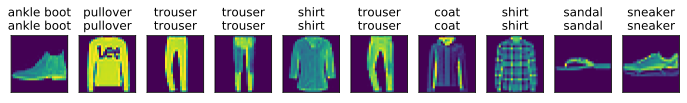

In [20]:
# prediction
X,y = next(iter(test_iter))
model = softmax_regression
true_labels = d2l.get_fashion_mnist_labels(y.numpy())
pred_labels = d2l.get_fashion_mnist_labels(model(X).argmax(dim=1).numpy())
titles = [true + '\n' + pred for true, pred in zip(true_labels, pred_labels)]
d2l.show_fashion_mnist(X[:10], titles[0:10])

# softmax回归的简洁实现

In [21]:
import torch
from torch import nn
from torch.nn import init
import numpy as np
import sys
sys.path.append("..") 
import d2lzh_pytorch as d2l

In [22]:
# 小批量读取
batch_size = 256
if sys.platform.startswith('win'):
    num_workers = 0
else:
    num_workers = 4

train_iter = torch.utils.data.DataLoader(mnist_train, batch_size, 
                                         shuffle=True, num_workers=num_workers)
test_iter = torch.utils.data.DataLoader(mnist_test, batch_size,
                                       shuffle=False, num_workers=num_workers)

In [24]:
num_inputs = 784
num_outputs = 10

# 方法1

class LinearNet(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(LinearNet, self).__init__()
        self.fc1 = nn.Linear(num_inputs, num_outputs)
    def forward(self, x): # x: (batch_size, 1, 28, 28)
        y = self.fc1(x.view(x.shape[0],-1))
        return y
    
model = LinearNet(num_inputs, num_outputs)
model

LinearNet(
  (fc1): Linear(in_features=784, out_features=10, bias=True)
)

In [25]:
#方法二
from collections import OrderedDict

class FlattenLayer(nn.Module):
    def __init__(self):
        super(FlattenLayer, self).__init__()
    def forward(self, x):
        return x.view(x.shape[0],-1)

model_1 = nn.Sequential(
    OrderedDict([
        ('flatten', FlattenLayer()),
        ('linear', nn.Linear(num_inputs, num_outputs))
    ]))

# 方法三
model_2 = nn.Sequential(
FlattenLayer(),
nn.Linear(num_inputs, num_outputs)
)
print(model_1)
print(model_2)

Sequential(
  (flatten): FlattenLayer()
  (linear): Linear(in_features=784, out_features=10, bias=True)
)
Sequential(
  (0): FlattenLayer()
  (1): Linear(in_features=784, out_features=10, bias=True)
)


In [26]:
# 初始化权重参数
init.normal_(model.fc1.weight, mean=0, std=0.01)
init.constant_(model.fc1.bias, val=0)

# 损失函数
loss = nn.CrossEntropyLoss()

# 优化器
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

num_epochs = 5
train(model, train_iter, test_iter, loss, num_epochs, batch_size, params=None, lr=None, optimizer=optimizer)

epoch 1 loss 0.0031  train acc  0.7520  test acc  0.7812
epoch 2 loss 0.0022  train acc  0.8130  test acc  0.8106
epoch 3 loss 0.0021  train acc  0.8250  test acc  0.8122
epoch 4 loss 0.0020  train acc  0.8319  test acc  0.8127
epoch 5 loss 0.0019  train acc  0.8380  test acc  0.8194
